In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
from io import BytesIO
from PIL import Image

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [4]:
DATASET                 = "archive.zip"
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16, 16, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
image_size              = 128
CHANNELS_IMG            = 3
Z_DIM                   = 256  # should be 512 in original paper
IN_CHANNELS             = 256  # should be 512 in original paper
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)

In [5]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [12]:
def image_batch_generator(zip_file, transform=None):
#     with zipfile.ZipFile(zip_file, 'r') as z:
#         image_files = [f for f in z.namelist() if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
#         total_images = len(image_files)
#         images = []
#         for i in range(0, total_images):
#             batch_files = image_files[i]
#             with z.open(batch_files) as file:
#                 img = Image.open(BytesIO(file.read())).convert('RGB')
#                 if transform:
#                     img = transform(img)
#                 images.append(img)
    all_image_files = []
    for root, _, files in os.walk(zip_file):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                all_image_files.append(os.path.join(root, file))
    images = []
    total_images = len(all_image_files)
    
    for i in range(0, total_images):
        batch_files = all_image_files[i]
        img = Image.open(batch_files).convert('RGB')
        if transform:
            img = transform(img)
        images.append(img)
    return images


def get_loader(zipfile,image_size):

    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = image_batch_generator(zipfile, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset

In [ ]:
get_loader("/kaggle/input/art-portraits",4)

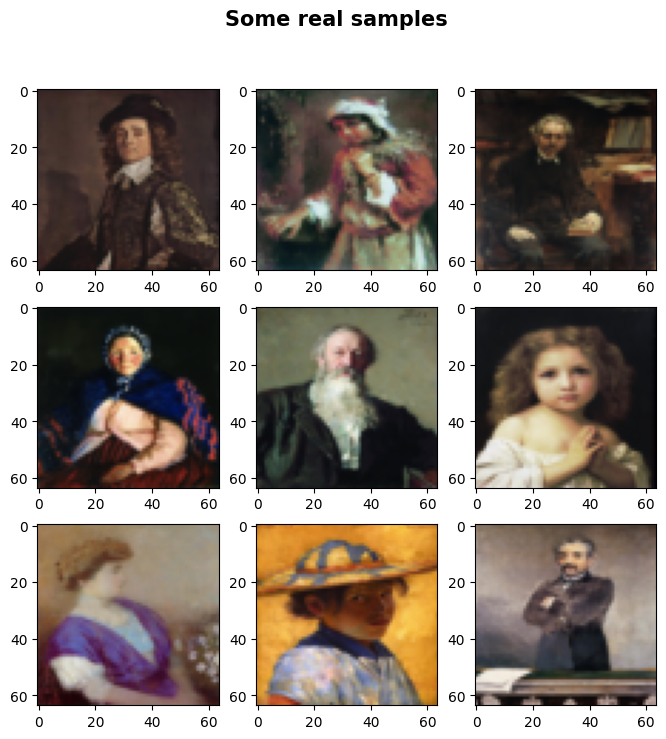

In [14]:
def check_loader():
    loader,_ = get_loader("/kaggle/input/art-portraits",64)
    cloth = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
check_loader()

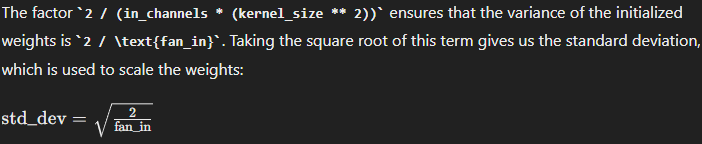

# (w * in_scale) * x = w * (x * in_scale)

In [15]:
class WSConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(WSConv2d, self).__init__()
        self.conv      = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # this is the part where weights though initialized using xevier or normal but without scaling{on the basis of input}
        # The term in_channels * (kernel_size ** 2) represents the total number of input connections (fan-in) to a particular neuron in the convolutional layer
        self.scale     = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias      = self.conv.bias 
        self.conv.bias = None      

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        # (w * in_scale) * x = w * (x * in_scale)
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

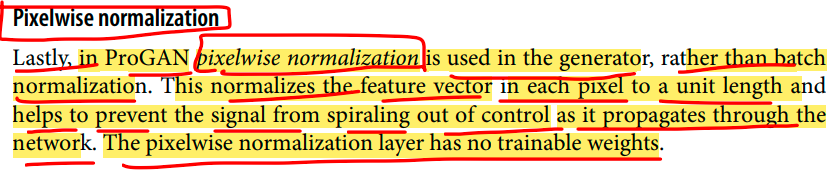

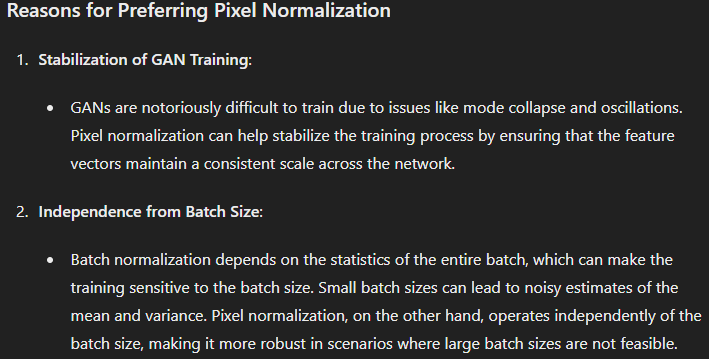

In [16]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon) 

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1  = WSConv2d(in_channels, out_channels)
        self.conv2  = WSConv2d(out_channels, out_channels)
        self.leaky  = nn.LeakyReLU(0.2)
        self.pn     = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

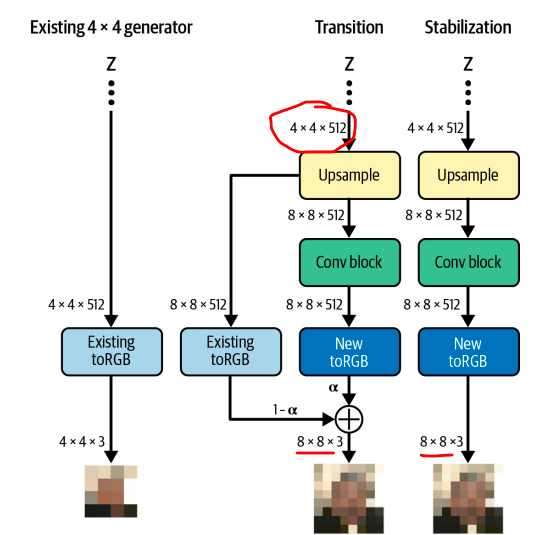

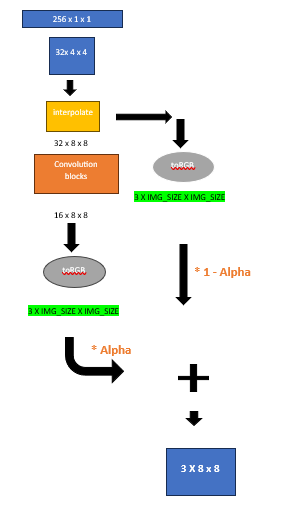

In [18]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]
        #         256 '  '  '   128    64     32     8       4
    
        for i in range( len(factors) - 1):  
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )


    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps): # [ 512, 1, 1 ]
        out = self.initial(x) # [1, 32, 4, 4]
        
        if steps == 0:
            return self.initial_rgb(out) # [1, 32, 4, 4]

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")   # ( C, 8, 8), (C, 16, 16), ( C, 32, 32)
            out = self.prog_blocks[step](upscaled) # channels :: 32 -> 32 -> 32  -> 16 -> 8

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled) # 3 * 32 * 32
        final_out = self.rgb_layers[steps](out) # Current_channel -> output_img_channel [1, 3, 32, 32]
    
        return self.fade_in(alpha, final_upscaled, final_out)

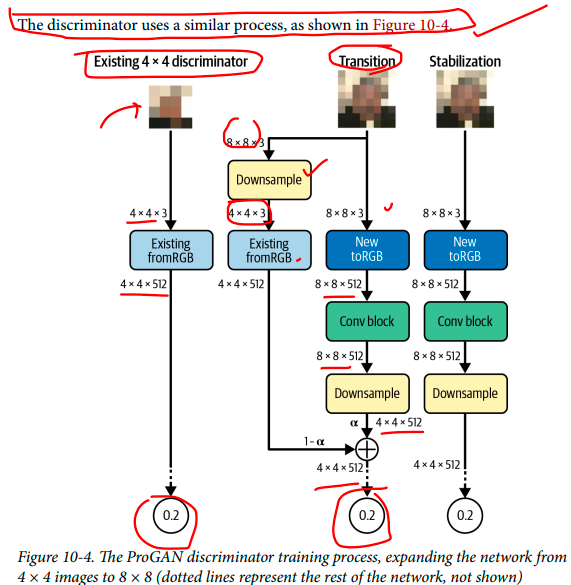

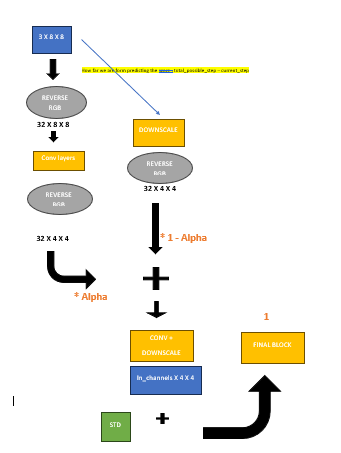

In [19]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            

        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):  # [ 1, 3, 256, 256 ]

        cur_step = len(self.prog_blocks) - steps

        out = self.leaky(self.rgb_layers[cur_step](x))          # [1, 32, 256, 256]

        if steps == 0:  
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)
        

        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x))) # [1, 32, 128, 128]
        out = self.avg_pool(self.prog_blocks[cur_step](out))                     # [1, 32, 128, 128]

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)  #  [ 16, 128, 128 ]

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [20]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [21]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [26]:
torch.save(gen.state_dict(), "genweights.pth")

In [22]:
def train_fn(critic,gen,loader,dataset,step,alpha,opt_critic,opt_gen):
    loop = tqdm(loader, leave=True)
    for batch_idx, real in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )
        

    return alpha


In [27]:
step

6

In [24]:
# initialize gen and disc, note: discriminator we called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(
    IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)

gen.train()
critic.train()

step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS:
    alpha = 1e-5  # start with very low alpha, you can start with alpha=0
    loader, dataset = get_loader("/kaggle/input/art-portraits",4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
        )
    generate_examples(gen, step, n=100)


    step += 1  # progress to the next img size

Current image size: 4
Epoch [1/30]


100%|██████████| 333/333 [00:06<00:00, 51.37it/s, gp=0.0151, loss_critic=0.159]  


Epoch [2/30]


100%|██████████| 333/333 [00:05<00:00, 62.00it/s, gp=0.00309, loss_critic=-0.154]  


Epoch [3/30]


100%|██████████| 333/333 [00:05<00:00, 65.11it/s, gp=0.00852, loss_critic=-0.285]   


Epoch [4/30]


100%|██████████| 333/333 [00:05<00:00, 65.28it/s, gp=0.0064, loss_critic=-0.0288]  


Epoch [5/30]


100%|██████████| 333/333 [00:05<00:00, 64.12it/s, gp=0.00393, loss_critic=-0.278]  


Epoch [6/30]


100%|██████████| 333/333 [00:05<00:00, 65.20it/s, gp=0.0119, loss_critic=0.276]     


Epoch [7/30]


100%|██████████| 333/333 [00:05<00:00, 64.79it/s, gp=0.0126, loss_critic=0.572]    


Epoch [8/30]


100%|██████████| 333/333 [00:05<00:00, 64.04it/s, gp=0.00213, loss_critic=-0.173]  


Epoch [9/30]


100%|██████████| 333/333 [00:05<00:00, 65.33it/s, gp=0.00659, loss_critic=-0.271]   


Epoch [10/30]


100%|██████████| 333/333 [00:05<00:00, 64.94it/s, gp=0.00388, loss_critic=-0.398]   


Epoch [11/30]


100%|██████████| 333/333 [00:05<00:00, 64.49it/s, gp=0.000773, loss_critic=0.0851]  


Epoch [12/30]


100%|██████████| 333/333 [00:05<00:00, 65.04it/s, gp=0.00347, loss_critic=0.336]    


Epoch [13/30]


100%|██████████| 333/333 [00:05<00:00, 65.11it/s, gp=0.00583, loss_critic=0.13]     


Epoch [14/30]


100%|██████████| 333/333 [00:05<00:00, 63.65it/s, gp=0.00402, loss_critic=0.155]    


Epoch [15/30]


100%|██████████| 333/333 [00:05<00:00, 64.63it/s, gp=0.0127, loss_critic=0.134]     


Epoch [16/30]


100%|██████████| 333/333 [00:05<00:00, 64.88it/s, gp=0.00341, loss_critic=-0.0326] 


Epoch [17/30]


100%|██████████| 333/333 [00:05<00:00, 64.67it/s, gp=0.00136, loss_critic=-0.0896] 


Epoch [18/30]


100%|██████████| 333/333 [00:05<00:00, 65.74it/s, gp=0.00157, loss_critic=-0.00536]


Epoch [19/30]


100%|██████████| 333/333 [00:05<00:00, 65.36it/s, gp=0.00207, loss_critic=-0.0077]  


Epoch [20/30]


100%|██████████| 333/333 [00:05<00:00, 64.59it/s, gp=0.00195, loss_critic=-0.0634] 


Epoch [21/30]


100%|██████████| 333/333 [00:05<00:00, 65.01it/s, gp=0.00536, loss_critic=0.185]    


Epoch [22/30]


100%|██████████| 333/333 [00:05<00:00, 65.36it/s, gp=0.00657, loss_critic=0.141]    


Epoch [23/30]


100%|██████████| 333/333 [00:05<00:00, 64.78it/s, gp=0.00411, loss_critic=-0.116]  


Epoch [24/30]


100%|██████████| 333/333 [00:05<00:00, 65.92it/s, gp=0.0058, loss_critic=-0.526]   


Epoch [25/30]


100%|██████████| 333/333 [00:05<00:00, 63.74it/s, gp=0.00164, loss_critic=0.301]   


Epoch [26/30]


100%|██████████| 333/333 [00:05<00:00, 63.12it/s, gp=0.00753, loss_critic=0.129]    


Epoch [27/30]


100%|██████████| 333/333 [00:05<00:00, 65.77it/s, gp=0.00277, loss_critic=0.0638]   


Epoch [28/30]


100%|██████████| 333/333 [00:05<00:00, 65.23it/s, gp=0.00256, loss_critic=0.201]   


Epoch [29/30]


100%|██████████| 333/333 [00:05<00:00, 65.61it/s, gp=0.00155, loss_critic=0.16]    


Epoch [30/30]


100%|██████████| 333/333 [00:05<00:00, 65.10it/s, gp=0.00492, loss_critic=0.0366]   


Current image size: 8
Epoch [1/30]


100%|██████████| 333/333 [00:09<00:00, 36.21it/s, gp=0.00375, loss_critic=0.135]  


Epoch [2/30]


100%|██████████| 333/333 [00:09<00:00, 36.60it/s, gp=0.00812, loss_critic=-0.5]    


Epoch [3/30]


100%|██████████| 333/333 [00:09<00:00, 36.06it/s, gp=0.00346, loss_critic=0.582]   


Epoch [4/30]


100%|██████████| 333/333 [00:09<00:00, 36.62it/s, gp=0.00467, loss_critic=0.0996]  


Epoch [5/30]


100%|██████████| 333/333 [00:09<00:00, 36.51it/s, gp=0.00134, loss_critic=0.0899]   


Epoch [6/30]


100%|██████████| 333/333 [00:09<00:00, 36.41it/s, gp=0.00295, loss_critic=-0.778]  


Epoch [7/30]


100%|██████████| 333/333 [00:09<00:00, 36.10it/s, gp=0.012, loss_critic=-0.0109]   


Epoch [8/30]


100%|██████████| 333/333 [00:09<00:00, 36.53it/s, gp=0.0081, loss_critic=0.475]    


Epoch [9/30]


100%|██████████| 333/333 [00:09<00:00, 36.60it/s, gp=0.00454, loss_critic=0.0295]  


Epoch [10/30]


100%|██████████| 333/333 [00:09<00:00, 36.20it/s, gp=0.00378, loss_critic=0.398]   


Epoch [11/30]


100%|██████████| 333/333 [00:09<00:00, 36.77it/s, gp=0.00808, loss_critic=-0.404]   


Epoch [12/30]


100%|██████████| 333/333 [00:09<00:00, 36.92it/s, gp=0.00201, loss_critic=-0.371]  


Epoch [13/30]


100%|██████████| 333/333 [00:09<00:00, 36.98it/s, gp=0.0104, loss_critic=-0.309]   


Epoch [14/30]


100%|██████████| 333/333 [00:09<00:00, 36.70it/s, gp=0.00465, loss_critic=-0.0969]  


Epoch [15/30]


100%|██████████| 333/333 [00:08<00:00, 37.08it/s, gp=0.00562, loss_critic=-0.467]  


Epoch [16/30]


100%|██████████| 333/333 [00:09<00:00, 36.93it/s, gp=0.00765, loss_critic=0.115]   


Epoch [17/30]


100%|██████████| 333/333 [00:09<00:00, 36.77it/s, gp=0.00187, loss_critic=-0.122]  


Epoch [18/30]


100%|██████████| 333/333 [00:09<00:00, 36.94it/s, gp=0.00349, loss_critic=0.106]   


Epoch [19/30]


100%|██████████| 333/333 [00:08<00:00, 37.07it/s, gp=0.00372, loss_critic=0.552]   


Epoch [20/30]


100%|██████████| 333/333 [00:09<00:00, 36.90it/s, gp=0.0133, loss_critic=-0.774]   


Epoch [21/30]


100%|██████████| 333/333 [00:09<00:00, 36.64it/s, gp=0.0139, loss_critic=0.369]     


Epoch [22/30]


100%|██████████| 333/333 [00:09<00:00, 36.93it/s, gp=0.00455, loss_critic=-0.229]  


Epoch [23/30]


100%|██████████| 333/333 [00:09<00:00, 36.75it/s, gp=0.00378, loss_critic=-0.0921]  


Epoch [24/30]


100%|██████████| 333/333 [00:09<00:00, 36.31it/s, gp=0.00779, loss_critic=-0.141]  


Epoch [25/30]


100%|██████████| 333/333 [00:09<00:00, 36.61it/s, gp=0.00584, loss_critic=0.237]   


Epoch [26/30]


100%|██████████| 333/333 [00:08<00:00, 37.11it/s, gp=0.011, loss_critic=-0.373]    


Epoch [27/30]


100%|██████████| 333/333 [00:09<00:00, 36.92it/s, gp=0.00529, loss_critic=0.117]   


Epoch [28/30]


100%|██████████| 333/333 [00:08<00:00, 37.08it/s, gp=0.00353, loss_critic=0.419]    


Epoch [29/30]


100%|██████████| 333/333 [00:08<00:00, 37.04it/s, gp=0.00667, loss_critic=0.0419]   


Epoch [30/30]


100%|██████████| 333/333 [00:09<00:00, 36.92it/s, gp=0.00695, loss_critic=-0.0421]  


Current image size: 16
Epoch [1/30]


100%|██████████| 333/333 [00:18<00:00, 17.91it/s, gp=0.00171, loss_critic=0.94]    


Epoch [2/30]


100%|██████████| 333/333 [00:18<00:00, 17.95it/s, gp=0.0504, loss_critic=-1.27]   


Epoch [3/30]


100%|██████████| 333/333 [00:18<00:00, 17.95it/s, gp=0.000911, loss_critic=-1.59]  


Epoch [4/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.00256, loss_critic=-0.535] 


Epoch [5/30]


100%|██████████| 333/333 [00:18<00:00, 17.92it/s, gp=0.000931, loss_critic=0.566]  


Epoch [6/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.00324, loss_critic=-0.0159] 


Epoch [7/30]


100%|██████████| 333/333 [00:18<00:00, 17.95it/s, gp=0.00342, loss_critic=-0.517]   


Epoch [8/30]


100%|██████████| 333/333 [00:18<00:00, 17.94it/s, gp=0.00396, loss_critic=-0.633]   


Epoch [9/30]


100%|██████████| 333/333 [00:18<00:00, 17.94it/s, gp=0.0025, loss_critic=0.892]    


Epoch [10/30]


100%|██████████| 333/333 [00:18<00:00, 17.93it/s, gp=0.00559, loss_critic=-0.577]  


Epoch [11/30]


100%|██████████| 333/333 [00:18<00:00, 17.97it/s, gp=0.0226, loss_critic=0.034]    


Epoch [12/30]


100%|██████████| 333/333 [00:18<00:00, 17.94it/s, gp=0.00922, loss_critic=0.943]   


Epoch [13/30]


100%|██████████| 333/333 [00:18<00:00, 17.94it/s, gp=0.00119, loss_critic=-0.0429] 


Epoch [14/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.0128, loss_critic=0.00617]   


Epoch [15/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.00621, loss_critic=-0.216]  


Epoch [16/30]


100%|██████████| 333/333 [00:18<00:00, 17.98it/s, gp=0.00203, loss_critic=-0.884]  


Epoch [17/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.00352, loss_critic=-1.07]   


Epoch [18/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.00539, loss_critic=0.0121]   


Epoch [19/30]


100%|██████████| 333/333 [00:18<00:00, 17.97it/s, gp=0.00832, loss_critic=-1.34]    


Epoch [20/30]


100%|██████████| 333/333 [00:18<00:00, 17.95it/s, gp=0.00273, loss_critic=-0.303]  


Epoch [21/30]


100%|██████████| 333/333 [00:18<00:00, 17.95it/s, gp=0.00372, loss_critic=-1.37]    


Epoch [22/30]


100%|██████████| 333/333 [00:18<00:00, 17.94it/s, gp=0.0057, loss_critic=0.0714]    


Epoch [23/30]


100%|██████████| 333/333 [00:18<00:00, 17.97it/s, gp=0.000696, loss_critic=-0.171] 


Epoch [24/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.00434, loss_critic=-0.797]  


Epoch [25/30]


100%|██████████| 333/333 [00:18<00:00, 17.95it/s, gp=0.00535, loss_critic=0.235]    


Epoch [26/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.0129, loss_critic=0.723]   


Epoch [27/30]


100%|██████████| 333/333 [00:18<00:00, 17.95it/s, gp=0.00378, loss_critic=-0.0211] 


Epoch [28/30]


100%|██████████| 333/333 [00:18<00:00, 17.97it/s, gp=0.00632, loss_critic=0.0604]  


Epoch [29/30]


100%|██████████| 333/333 [00:18<00:00, 17.97it/s, gp=0.00452, loss_critic=-0.0732] 


Epoch [30/30]


100%|██████████| 333/333 [00:18<00:00, 17.96it/s, gp=0.00118, loss_critic=-0.144]  


Current image size: 32
Epoch [1/30]


100%|██████████| 665/665 [01:18<00:00,  8.49it/s, gp=0.00374, loss_critic=0.114]  


Epoch [2/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0136, loss_critic=-0.706]  


Epoch [3/30]


100%|██████████| 665/665 [01:18<00:00,  8.49it/s, gp=0.0157, loss_critic=0.402]   


Epoch [4/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00809, loss_critic=-1.46]   


Epoch [5/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0416, loss_critic=0.798]     


Epoch [6/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0627, loss_critic=0.323]    


Epoch [7/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0281, loss_critic=-0.101]   


Epoch [8/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0314, loss_critic=-0.541]    


Epoch [9/30]


100%|██████████| 665/665 [01:18<00:00,  8.49it/s, gp=0.00333, loss_critic=0.209]   


Epoch [10/30]


100%|██████████| 665/665 [01:18<00:00,  8.49it/s, gp=0.00557, loss_critic=0.153]    


Epoch [11/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.015, loss_critic=-0.664]    


Epoch [12/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00246, loss_critic=-0.487]  


Epoch [13/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00168, loss_critic=0.391]   


Epoch [14/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00351, loss_critic=2.66]    


Epoch [15/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0059, loss_critic=-0.549]   


Epoch [16/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0182, loss_critic=0.0766]   


Epoch [17/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00222, loss_critic=-0.732]  


Epoch [18/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00786, loss_critic=-0.55]   


Epoch [19/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00616, loss_critic=-0.867]   


Epoch [20/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00888, loss_critic=0.184]   


Epoch [21/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00578, loss_critic=-0.378]  


Epoch [22/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.0101, loss_critic=0.461]    


Epoch [23/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00109, loss_critic=-0.515]  


Epoch [24/30]


100%|██████████| 665/665 [01:18<00:00,  8.49it/s, gp=0.00148, loss_critic=-1.93]    


Epoch [25/30]


100%|██████████| 665/665 [01:18<00:00,  8.48it/s, gp=0.00269, loss_critic=-0.405]  


Epoch [26/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00969, loss_critic=2.79]    


Epoch [27/30]


100%|██████████| 665/665 [01:18<00:00,  8.50it/s, gp=0.00219, loss_critic=-1.54]    


Epoch [28/30]


100%|██████████| 665/665 [01:18<00:00,  8.48it/s, gp=0.00227, loss_critic=-2.13]   


Epoch [29/30]


100%|██████████| 665/665 [01:18<00:00,  8.45it/s, gp=0.00691, loss_critic=0.494]   


Epoch [30/30]


100%|██████████| 665/665 [01:18<00:00,  8.47it/s, gp=0.0199, loss_critic=-0.14]    


Current image size: 64
Epoch [1/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0913, loss_critic=1.46]    


Epoch [2/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0409, loss_critic=0.777]  


Epoch [3/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.184, loss_critic=2.02]     


Epoch [4/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0566, loss_critic=0.355]   


Epoch [5/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.022, loss_critic=0.167]    


Epoch [6/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0346, loss_critic=0.264]   


Epoch [7/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0161, loss_critic=0.699]   


Epoch [8/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0536, loss_critic=1.93]    


Epoch [9/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.00342, loss_critic=0.0295]  


Epoch [10/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0249, loss_critic=0.352]   


Epoch [11/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0274, loss_critic=0.311]    


Epoch [12/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.00275, loss_critic=0.754]   


Epoch [13/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.034, loss_critic=1.08]      


Epoch [14/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0285, loss_critic=1.15]     


Epoch [15/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0116, loss_critic=-3.43]   


Epoch [16/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0275, loss_critic=-0.894]  


Epoch [17/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.362, loss_critic=5.95]     


Epoch [18/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0224, loss_critic=0.486]    


Epoch [19/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0144, loss_critic=2.39]    


Epoch [20/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0184, loss_critic=0.71]    


Epoch [21/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0113, loss_critic=0.365]   


Epoch [22/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0717, loss_critic=0.499]    


Epoch [23/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0157, loss_critic=-0.396]  


Epoch [24/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0353, loss_critic=1.04]    


Epoch [25/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0838, loss_critic=2.05]     


Epoch [26/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0216, loss_critic=-0.953]  


Epoch [27/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0796, loss_critic=-1.65]    


Epoch [28/30]


100%|██████████| 665/665 [03:13<00:00,  3.43it/s, gp=0.0468, loss_critic=3.19]    


Epoch [29/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.0145, loss_critic=-1.49]   


Epoch [30/30]


100%|██████████| 665/665 [03:13<00:00,  3.44it/s, gp=0.047, loss_critic=1.54]     


Current image size: 128
Epoch [1/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0197, loss_critic=-2.45]   


Epoch [2/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.0273, loss_critic=-4.44]  


Epoch [3/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.011, loss_critic=-2.35]   


Epoch [4/30]


100%|██████████| 665/665 [07:21<00:00,  1.51it/s, gp=0.0269, loss_critic=-3.42]  


Epoch [5/30]


100%|██████████| 665/665 [07:21<00:00,  1.51it/s, gp=0.0129, loss_critic=-4.8]    


Epoch [6/30]


100%|██████████| 665/665 [07:21<00:00,  1.51it/s, gp=0.025, loss_critic=3.67]     


Epoch [7/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.00547, loss_critic=-1.72]  


Epoch [8/30]


100%|██████████| 665/665 [07:21<00:00,  1.51it/s, gp=0.0188, loss_critic=-3.71]   


Epoch [9/30]


100%|██████████| 665/665 [07:21<00:00,  1.51it/s, gp=0.0287, loss_critic=-0.365]  


Epoch [10/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.0222, loss_critic=-5.05]   


Epoch [11/30]


100%|██████████| 665/665 [07:21<00:00,  1.51it/s, gp=0.0159, loss_critic=-5.52]    


Epoch [12/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0109, loss_critic=-1.22]   


Epoch [13/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.00513, loss_critic=-4.79]  


Epoch [14/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0191, loss_critic=1.1]      


Epoch [15/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.00589, loss_critic=2.78]   


Epoch [16/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.0417, loss_critic=-1.36]   


Epoch [17/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.0834, loss_critic=-1.99]  


Epoch [18/30]


100%|██████████| 665/665 [07:21<00:00,  1.51it/s, gp=0.00189, loss_critic=-1.34]   


Epoch [19/30]


100%|██████████| 665/665 [07:21<00:00,  1.50it/s, gp=0.00837, loss_critic=2.6]   


Epoch [20/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0143, loss_critic=-2.53]   


Epoch [21/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.01, loss_critic=-0.854]    


Epoch [22/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.00419, loss_critic=-3.14]  


Epoch [23/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0188, loss_critic=1.44]    


Epoch [24/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.00625, loss_critic=-6.75] 


Epoch [25/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.00924, loss_critic=-1.76]  


Epoch [26/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0212, loss_critic=6.7]      


Epoch [27/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0143, loss_critic=-0.338]   


Epoch [28/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.02, loss_critic=-1.37]     


Epoch [29/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.00253, loss_critic=-2.26]  


Epoch [30/30]


100%|██████████| 665/665 [07:22<00:00,  1.50it/s, gp=0.0263, loss_critic=0.152]   


In [ ]:
alpha = 1e-5  # start with very low alpha, you can start with alpha=0
step = 5
loader, dataset = get_loader("/kaggle/input/art-portraits",5)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
print(f"Current image size: {4 * 2 ** step}")



In [32]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    alpha = train_fn(
        critic,
        gen,
        loader,
        dataset,
        step,
        alpha,
        opt_critic,
        opt_gen,
    )
generate_examples(gen, step, n=100)

Epoch [1/30]


  0%|          | 0/333 [00:00<?, ?it/s]


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

In [31]:
generate_examples(gen, 6, n=100)